# Test Evaluation

In [1]:
import os
import sys
import json
import collections
from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.nn import DataParallel
import torchvision
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sys.path.append("..")

from data import StyledCoco
import models
from CONFIG import CONFIG
import data
import data.custom_transforms as custom_transforms
import data.data_processing as data_processing
import lib.arguments as arguments
import lib.utils as utils
import lib.metrics as metrics
import lib.pose_parsing as pose_parsing 
import lib.visualizations as visualizations

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
test_exp = "test/experiment_2020-06-04_08-06-38"
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], test_exp)

In [4]:
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["dataset"]["dataset_name"] = "coco"

In [5]:
_, valid_loader = data.load_dataset(exp_data=exp_data, train=False,
                                    validation=True, shuffle_train=True,
                                    shuffle_valid=True)

loading annotations into memory...
Done (t=1.27s)
creating index...
index created!


In [6]:
len(valid_loader)

2693

## Testing Training/Inference

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.OpenPose()
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "OpenPose", "checkpoint_iter_370000.pth")
model.load_pretrained(pretrained_path)

model = DataParallel(model).to(device)
model.eval()
pass

In [8]:
def infer(model, img, stride=8):
    """
    Using the model to infer the heatmaps and pafs from an input image
    """
    
    img = img.float().to(device)
    stages_output = model(img)

    heatmaps = stages_output[-2].cpu().detach().numpy()[0,:]
    pafs = stages_output[-1].cpu().detach().numpy()[0,:]

    heatmaps = cv2.resize(heatmaps.transpose(1,2,0), (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC).transpose(2,0,1)
    pafs = cv2.resize(pafs.transpose(1,2,0), (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC).transpose(2,0,1)

    return heatmaps, pafs

In [9]:
img, _, _, _, metadata = next(iter(valid_loader))

In [10]:
img_name = metadata["image_name"]
img_shape = np.array(metadata["image_shape"][0])

print(img.shape)
print(img_shape)
print(img_name[0])

torch.Size([1, 3, 400, 400])
[640 416]
000000467511.jpg


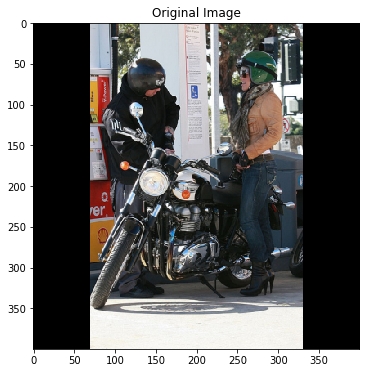

In [11]:
plt.figure(figsize=(6, 6))
ax = plt.gca()
visualizations.visualize_image(img[0,:].numpy(), ax=ax, title="Original Image")

In [12]:
heatmaps, pafs = infer(model=model, img=img)

In [13]:
_, keypoints = pose_parsing.extract_joins_heatmap(heatmaps, min_distance=1)

In [14]:
pose_entries, all_keypoints = pose_parsing.group_keypoints(keypoints, pafs)

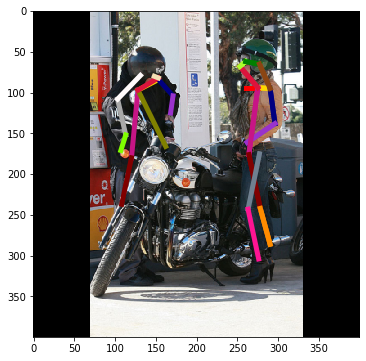

In [15]:
plt.figure(figsize=(6, 6))

ax = plt.gca()
title = "Predicted Poses"
visualizations.draw_pose(img[0,:].numpy(), pose_entries, all_keypoints, ax=ax, title=title)

plt.show()

In [16]:
def convert_to_coco_format(pose_entries, all_keypoints):
    """
    Converting detected poses and keypoints list to the format accepted 
    by COCO Evaluation
    """
    
    coco_keypoints = []
    scores = []
    
    for n in range(len(pose_entries)):
        if len(pose_entries[n]) == 0:
            continue
        keypoints = [0] * 17 * 3  # 17 keypoints (x,y,visibility) 
        to_coco_map = [0, -1, 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]
    
        person_score = pose_entries[n][-2]

        for position_id, keypoint_id in enumerate(pose_entries[n][:-2]):
            if position_id == 1:  # no 'neck' keypoint in COCO
                continue
            
            cx, cy, score, visibility = 0, 0, 0, 0  # keypoint not found
            if keypoint_id != -1:
                cx, cy, score = all_keypoints[int(keypoint_id), 0:3]
                visibility = 1
            keypoints[to_coco_map[position_id] * 3 + 0] = cx
            keypoints[to_coco_map[position_id] * 3 + 1] = cy
            keypoints[to_coco_map[position_id] * 3 + 2] = visibility

        coco_keypoints.append(keypoints)
        scores.append(person_score * max(0, (pose_entries[n][-1] - 1)))  # -1 for 'neck'
    
    return coco_keypoints, scores

In [17]:
coco_keypoints_, scores = data_processing.convert_to_coco_format(pose_entries, all_keypoints)

In [18]:
coco_keypoints = custom_transforms.resize_inference(coco_keypoints_, original_size=img_shape)

In [19]:
coco_result = []
image_id = int(img_name[0].split('.')[0])
for idx in range(len(coco_keypoints)):
    pts_add = []
    cur_points = coco_keypoints[idx]
    for i in range(len(cur_points)//3):
        y = cur_points[3*i + 0]
        x = cur_points[3*i + 1]
        v = cur_points[3*i + 2]
        pts_add += [x, y, v]
        
    coco_result.append({
        'image_id': image_id,
        'category_id': 1,  # person
        'keypoints': pts_add,
        'score': scores[idx]
    })

In [20]:
det_file = "test_detections.json"
with open(det_file, 'w') as f:
    json.dump(coco_result, f, indent=4)

In [21]:
data_path = CONFIG["paths"]["data_path"]
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")

In [22]:
with open(labels_file) as f:
    aux = json.load(f)

In [23]:
coco_gt = COCO(labels_file)
print("\n")
coco_dt = coco_gt.loadRes(det_file)

loading annotations into memory...
Done (t=1.09s)
creating index...
index created!


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [24]:
cocoEval = COCOeval(coco_gt, coco_dt, "keypoints")
cocoEval._prepare()

In [25]:
dets = cocoEval._dts[image_id, 1][0]
lbls = cocoEval._gts[image_id, 1][0]["keypoints"]
all_lbls = cocoEval._gts[image_id, 1]

In [26]:
dets_k = coco_keypoints_[0]
reshaped_dets_k = coco_keypoints[0]

print("IDX            Dets                Reshaped Dets   ----      Labels")
for i in range(len(dets_k)//3):
    if(dets_k[3*i+2] == 0):
        continue
    print(f"{i}:      {dets_k[3*i: 3*i+3]}   ----   {reshaped_dets_k[3*i: 3*i+3]}   ----   {lbls[3*i: 3*i+3]}")

IDX            Dets                Reshaped Dets   ----      Labels
0:      [68.0, 253.0, 1]   ----   [109, 293, 1]   ----   [294, 109, 2]
1:      [62.0, 260.0, 1]   ----   [99, 304, 1]   ----   [301, 101, 2]
3:      [65.0, 277.0, 1]   ----   [104, 331, 1]   ----   [328, 99, 2]
5:      [95.0, 290.0, 1]   ----   [152, 352, 1]   ----   [354, 157, 2]
6:      [94.0, 260.0, 1]   ----   [150, 304, 1]   ----   [322, 158, 2]
7:      [138.0, 296.0, 1]   ----   [221, 362, 1]   ----   [364, 213, 2]
9:      [161.0, 262.0, 1]   ----   [258, 307, 1]   ----   [305, 257, 2]
12:      [176.0, 264.0, 1]   ----   [282, 310, 1]   ----   [312, 273, 2]
14:      [242.0, 278.0, 1]   ----   [387, 333, 1]   ----   [328, 385, 2]
16:      [286.0, 290.0, 1]   ----   [458, 352, 1]   ----   [342, 484, 2]


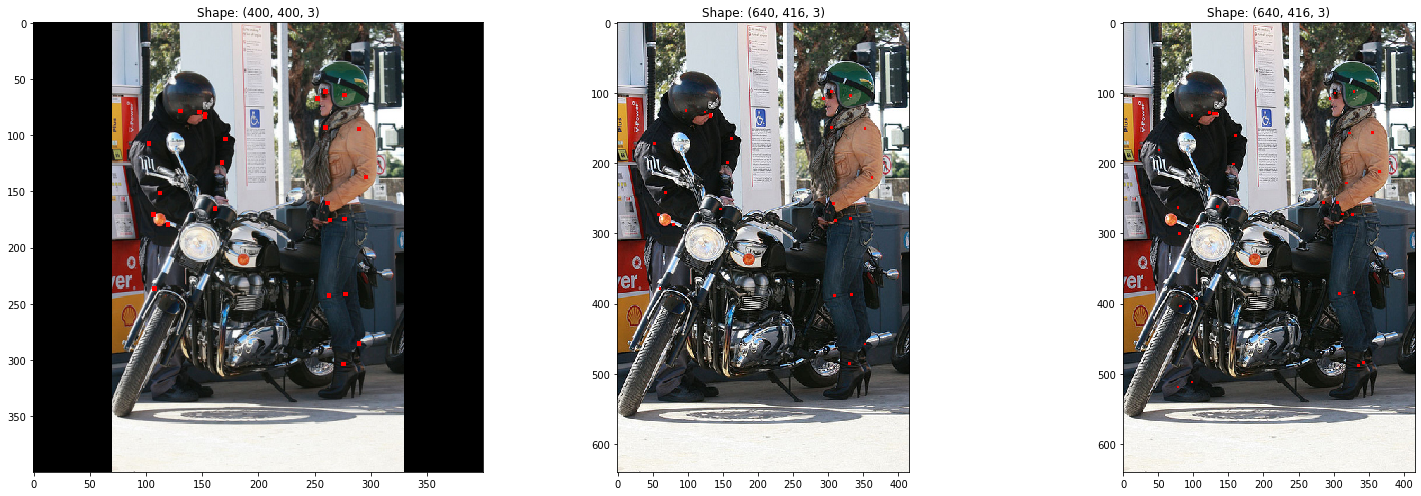

In [27]:
plt.figure(figsize=(22,7))

image_vis = np.array(img[0,:])
image_vis = np.array([image_vis[2,:,:], image_vis[1,:,:], image_vis[0,:,:]])
image_vis = image_vis.transpose(1,2,0)*256 + 128
image_vis = np.round(image_vis).astype(int)

offset = 2
for i in range(len(coco_keypoints_)):
    dets_k = coco_keypoints_[i]
    for kpt_idx in range(len(dets_k)//3):
        y = int(dets_k[3 * kpt_idx + 0])
        x = int(dets_k[3 * kpt_idx + 1])
        v = dets_k[3 * kpt_idx + 2]
        if(v != 0):
            image_vis[y-offset:y+offset, x-offset:x+offset, 0] = 255
            image_vis[y-offset:y+offset, x-offset:x+offset, 1:] = 0

plt.subplot(1,3,1)        
plt.title(f"Shape: {image_vis.shape}")
plt.imshow(image_vis)

data_path = CONFIG["paths"]["data_path"]
original_imgs_path = os.path.join(data_path, "original_images", "val2017")
or_img = cv2.imread(os.path.join(original_imgs_path, img_name[0]), cv2.IMREAD_COLOR)
or_img = np.array([or_img[:,:,2], or_img[:,:,1], or_img[:,:,0]])
or_img = or_img.transpose(1,2,0)

for i in range(len(coco_keypoints)):
    reshaped_dets_k = coco_keypoints[i]
    for kpt_idx in range(len(reshaped_dets_k)//3):
        y = int(reshaped_dets_k[3 * kpt_idx + 0])
        x = int(reshaped_dets_k[3 * kpt_idx + 1])
        v = reshaped_dets_k[3 * kpt_idx + 2]
        if(v != 0):
            or_img[y-offset:y+offset, x-offset:x+offset, 0] = 255
            or_img[y-offset:y+offset, x-offset:x+offset, 1:] = 0

plt.subplot(1,3,2)
plt.title(f"Shape: {or_img.shape}")
plt.imshow(or_img)
        

or_img = cv2.imread(os.path.join(original_imgs_path, img_name[0]), cv2.IMREAD_COLOR)
or_img = np.array([or_img[:,:,2], or_img[:,:,1], or_img[:,:,0]])
or_img = or_img.transpose(1,2,0)

for i in range(len(all_lbls)):
    lbls_k = all_lbls[i]["keypoints"]
    for kpt_idx in range(len(lbls_k)//3):
        x = int(lbls_k[3 * kpt_idx + 0])
        y = int(lbls_k[3 * kpt_idx + 1])
        v = lbls_k[3 * kpt_idx + 2]
        if(v != 0):
            or_img[y-offset:y+offset, x-offset:x+offset, 0] = 255
            or_img[y-offset:y+offset, x-offset:x+offset, 1:] = 0

plt.subplot(1,3,3)
plt.title(f"Shape: {or_img.shape}")
plt.imshow(or_img)
    
plt.tight_layout()
plt.show()

In [28]:
cocoEval.params.imgIds  = image_id

In [29]:
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.505
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.500
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.150
